In [1]:
%matplotlib inline

from pathlib import Path
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append(os.path.join(os.getcwd(), os.pardir, 'src'))

%load_ext autoreload

%autoreload 2
from visualization.visualize import *

In [3]:
who_df = pd.read_csv(Path("../data/interim/who_subnational_with_geocodes.csv"), index_col=0)
who_df.head(2)

,Iso Code,Country Name,WHO Region,Year,Vaccine Type,Admin1,Admin2,DenomType,Denominator,Numerator,...,recalc_numerator,available_admin,normalized_country,indicator,group,vaccine,timing,google_admin_1,google_admin_2,place_id
provenance,,,,,,,,,,,,,,,,,,,,,
who0,AFG,Afghanistan,EMRO,2016,BCG,NaN,Aab Band,1.0,1266.0,NaN,...,655.803767,Aab Band,afghanistan,1,BCG,BCG,1st_birth,Ghazni,Ab Band,ChIJ3zPu6yKg1TgRt22VHZjzwm4
who1151,AFG,Afghanistan,EMRO,2016,Pol3,NaN,Aab Band,2.0,1176.0,NaN,...,631.086291,Aab Band,afghanistan,1,Polio,Pol3,4th_14wks_6mos,Ghazni,Ab Band,ChIJ3zPu6yKg1TgRt22VHZjzwm4


In [4]:
wb = pd.read_csv(Path("../data/interim/external-processed/country_world_bank_indicators.csv"), index_col=0)
wb.head()

,crude_birth_rate_2016,population_2016,infant_mortality_rate_2016
Country Code,,,
ABW,10.963,104822.0,NaN
AFG,33.980,34656032.0,53.2
AGO,42.321,28813463.0,54.6
ALB,11.879,2876101.0,12.0
AND,9.500,77281.0,2.4


In [41]:
n_regions = (who_df.groupby(["Iso Code"])
                   .apply(lambda x: (x.google_admin_1 + x.google_admin_2).nunique()))

n_regions.sort_values(ascending=False)

Iso Code
BRA    5554
COL    1065
IND     613
MEX     521
ARG     495
IDN     471
PER     386
AFG     231
AGO     154
CUB     154
BOL     148
MOZ     137
GHA     135
PAK     100
MDG      91
SLV      84
RUS      83
ETH      77
GTM      76
BEN      73
CMR      68
BGD      64
CHL      63
PAN      59
COD      58
ECU      57
AZE      55
DOM      54
MMR      52
MLI      50
       ... 
BEL       3
VEN       2
TKM       2
GMB       2
UGA       2
TZA       1
GBR       1
UKR       1
URY       1
UZB       1
ARM       1
YEM       1
ZAF       1
BDI       1
TJK       1
TTO       1
TLS       1
CAF       1
THA       1
TGO       1
SWZ       1
SWE       1
SUR       1
SSD       1
SOM       1
SDN       1
LKA       1
ZMB       1
ESP       1
ZWE       1
Length: 136, dtype: int64

In [48]:
per_region_denoms = (who_df.groupby(["Iso Code", 'google_admin_1', 'google_admin_2', 'DenomType'])
                           .Denominator  
                           .max()
                           .unstack(-1)
                           [[1, 2]])

per_region_denoms.head()

DenomType                                   1.0      2.0
Iso Code google_admin_1 google_admin_2                  
AFG      Badakhshan     Darwaz           4722.0   4384.0
                        Fayzabad        12784.0  11870.0
                        Jurm             4572.0   4246.0
                        Kalafgan         6668.0   6192.0
                        Khwahan           837.0    777.0

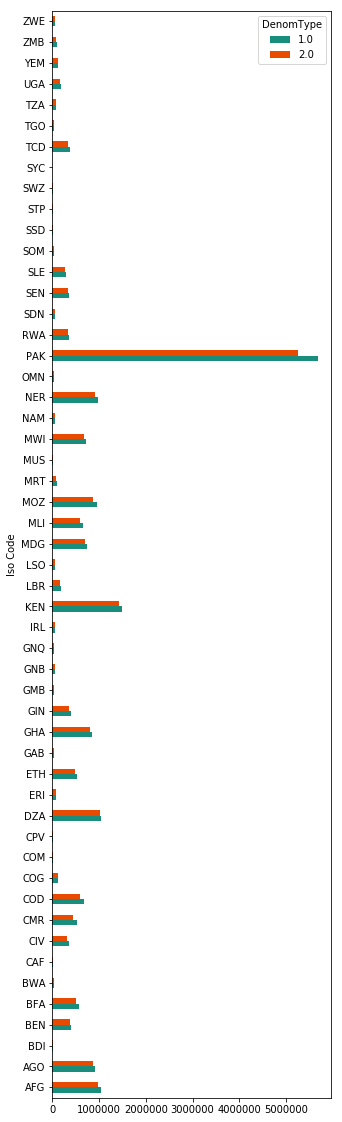

In [23]:
country_denoms = (per_region_denoms[[1, 2]]
                    .reset_index()
                    .groupby(['Iso Code'])
                    .sum()
                    .replace({0: np.nan})
                    .dropna(how='any'))

country_denoms.plot.barh(figsize=(5, 20))

In [36]:
remap = who_df[['Iso Code', 'Country Name']].drop_duplicates().set_index('Iso Code').to_dict()['Country Name']

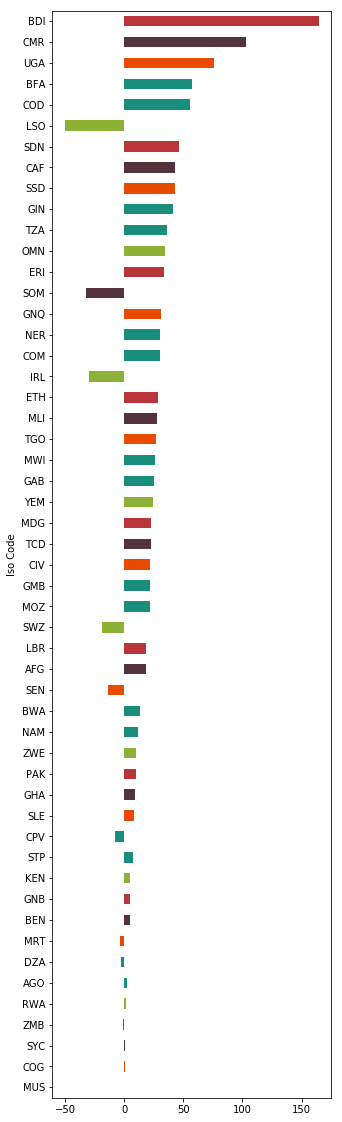

In [31]:
# sum births and infants at 1 by country

to_plot = (country_denoms.pipe(lambda x: 1000 * (x[1] - x[2]) / x[1])).to_frame().join(wb).pipe(lambda x: x[0] - x.infant_mortality_rate_2016)


to_plot[to_plot.abs().sort_values().index].plot.barh(figsize=(5, 20))
